In [1]:
import astra
import numpy as np
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from skimage import io
import tomopy

%matplotlib inline
import matplotlib.pyplot as plt
font = {'weight' : 'bold',
        'size'   : 22}
import matplotlib
matplotlib.rc('font', **font)

def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).sum(-1).sum(1)

def load_volume(filepath, extension, bin_factor=1):
    files = [file for file in np.sort(listdir(filepath)) if file.endswith(extension)]
    height, width = io.imread(join(filepath,files[0])).shape
    
    new_height, new_width = height//bin_factor, width//bin_factor
    depth = len(files)
    volume = np.zeros((depth, new_height, new_width))
    for i,file in tqdm(enumerate(files)):
        volume[i,:,:] = rebin(io.imread(join(filepath,file)), (new_height, new_width))

    volume = volume[:,:,:].astype('float32')
    return volume




### Performs reconstrcution of physical phantom data from Helsinki. The phantom consisted of spiral hair bands and play dough

I use tomopy and astra with a cuda card. Check that cuda is availble.

In [2]:
astra.astra.use_cuda()

True

Set the GPU to the largest GPU on the machine and print info to make sure it is correct.

In [3]:
astra.astra.set_gpu_index(0)
astra.astra.get_gpu_info()

'GPU #0: GeForce RTX 3090, with 24268MB'

Load the data

In [4]:
path = "/home/mette/remote-home/dikuTomography/WormConeBeam_Dec2019/20191213_worm_s/corrected"

data = load_volume(path, ".tif", bin_factor=1) 

data.nbytes

361it [01:00,  5.94it/s]


7659438080

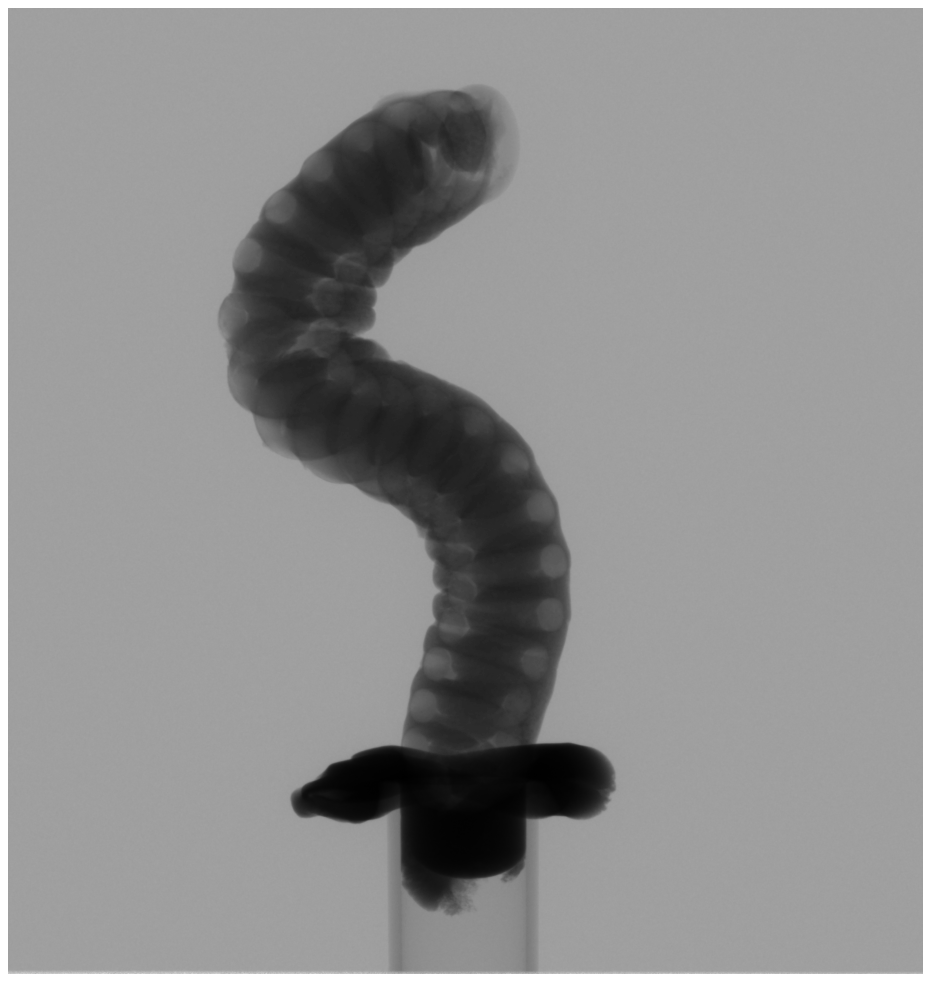

In [5]:
plt.figure(figsize=(16, 16), dpi=80)
plt.imshow(data[50,:,:], cmap="gray")
plt.axis("off")
plt.savefig("projectionS.png")

In [6]:
ang, r, c = data.shape
ang, r//2, c//2

(361, 1184, 1120)

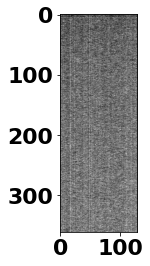

In [7]:
bkgd = data[:,:,0:128]
plt.imshow(bkgd[:,0,:], cmap="gray")

In [8]:
P = tomopy.minus_log(data[:,r//2,:]/np.mean(bkgd))
#Adjust center of rotation
P = np.roll(P, 1, axis=1)
#remove any "bad" values
P = tomopy.remove_nan(P, val=0.0)
P = tomopy.remove_neg(P, val=0.00)
P[np.where(P == np.inf)] = 0.00
P.shape

(361, 2240)

In [9]:
np.max(P), np.min(P)

(1.7808278, 0.0)

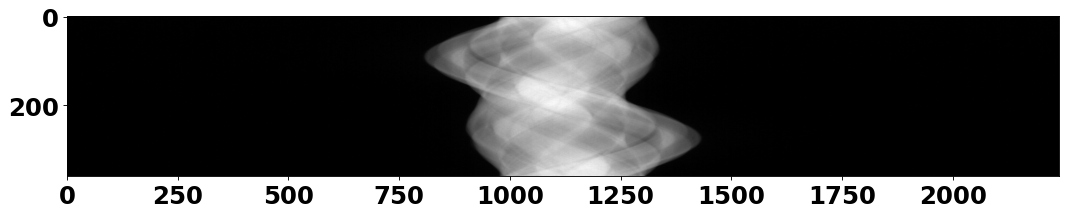

In [10]:
plt.figure(figsize=(16, 16), dpi=80)
plt.imshow(P, cmap="gray")
plt.savefig("sinogram361.png")

In [11]:
interval = 1
P = P[::interval,:]
P.shape

(361, 2240)

In [12]:
angles = np.linspace(0, 2*np.pi, 361, endpoint=False)
angles = angles[::interval]

In [13]:
#Configure geometry

distSourceDetectorMm = 630
distSourceOriginMm = 540
dso = distSourceOriginMm
dod = distSourceDetectorMm-distSourceOriginMm
det_pix_size = 120/c
d = (dso+dod)/det_pix_size
proj_geom = astra.create_proj_geom('fanflat',1.0, c, angles, d, 0)
vol_geom = astra.create_vol_geom(c,c)

#Data objects for input, output
sino_id = astra.data2d.create('-sino', proj_geom, P)
rec_id = astra.data2d.create('-vol', vol_geom)
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

# Configure algorithm
cfg = astra.astra_dict('FBP_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sino_id
cfg['ProjectorDataId'] = proj_id
alg_id = astra.algorithm.create(cfg)
# Run
astra.algorithm.run(alg_id, 100)
rec = astra.data2d.get(rec_id)

astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
astra.data3d.delete(proj_id)

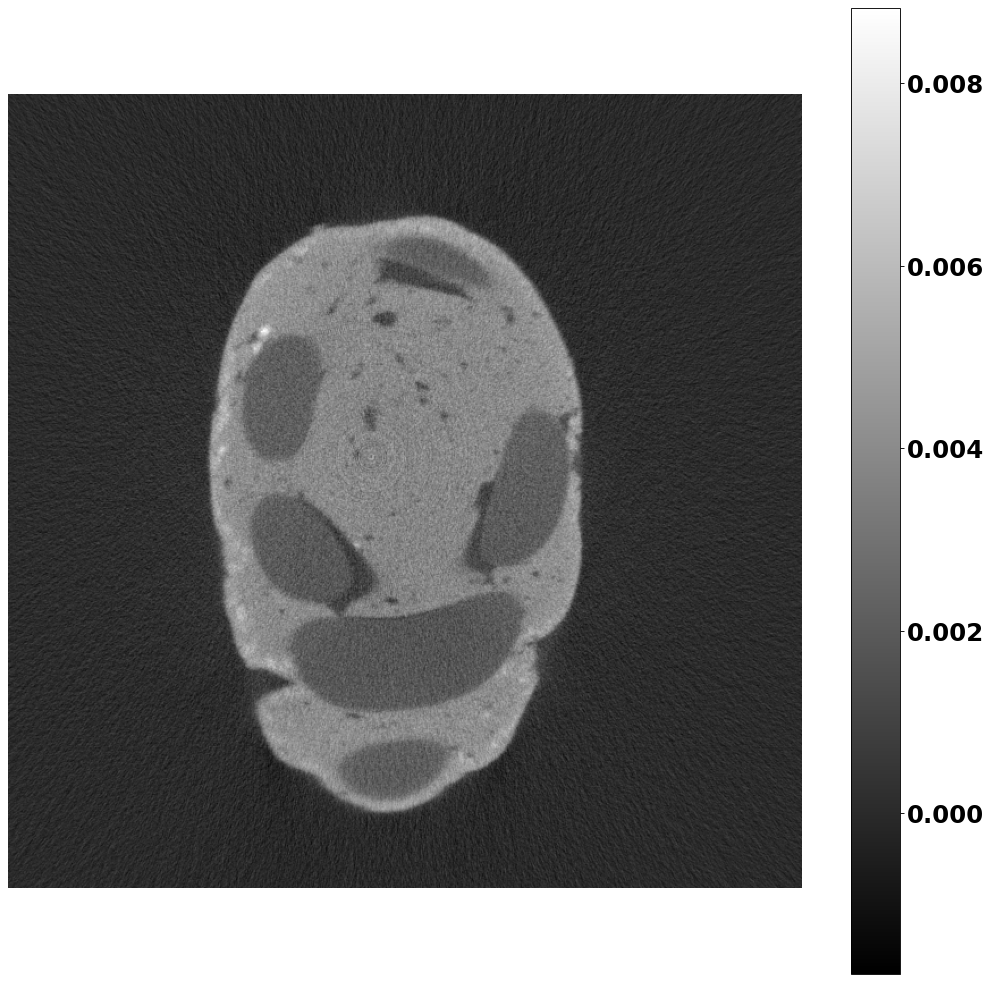

In [14]:
plt.figure(figsize=(16, 16), dpi=80)
plt.imshow(rec[800:1500,800:1500], cmap="gray")
plt.axis("off")
plt.colorbar()
plt.savefig("FBP361.png")

In [15]:
#Configure geometry
distSourceDetectorMm = 630
distSourceOriginMm = 540
dso = distSourceOriginMm
dod = distSourceDetectorMm-distSourceOriginMm
det_pix_size = 120/c
d = (dso+dod)/det_pix_size
proj_geom = astra.create_proj_geom('fanflat',1.0, c, angles, d, 0)
vol_geom = astra.create_vol_geom(c,c)

#Data objects for input, output
sino_id = astra.data2d.create('-sino', proj_geom, P)
rec_id = astra.data2d.create('-vol', vol_geom)
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

# Configure algorithm
cfg = astra.astra_dict('SIRT_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sino_id
cfg['ProjectorDataId'] = proj_id
cfg['option']={}
cfg['option']['MinConstraint'] = 0

alg_id = astra.algorithm.create(cfg)
# Run
# Run 1500 iterations of the algorithm one at a time, keeping track of errors
nIters = 1500
phantom_error = np.zeros(nIters)
residual_error = np.zeros(nIters)
for i in tqdm(range(nIters)):
    # Run a single iteration
    astra.algorithm.run(alg_id, 1)
    residual_error[i] = astra.algorithm.get_res_norm(alg_id)
    
rec = astra.data2d.get(rec_id)

astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
astra.data3d.delete(proj_id)



100%|██████████| 1500/1500 [01:28<00:00, 16.93it/s]


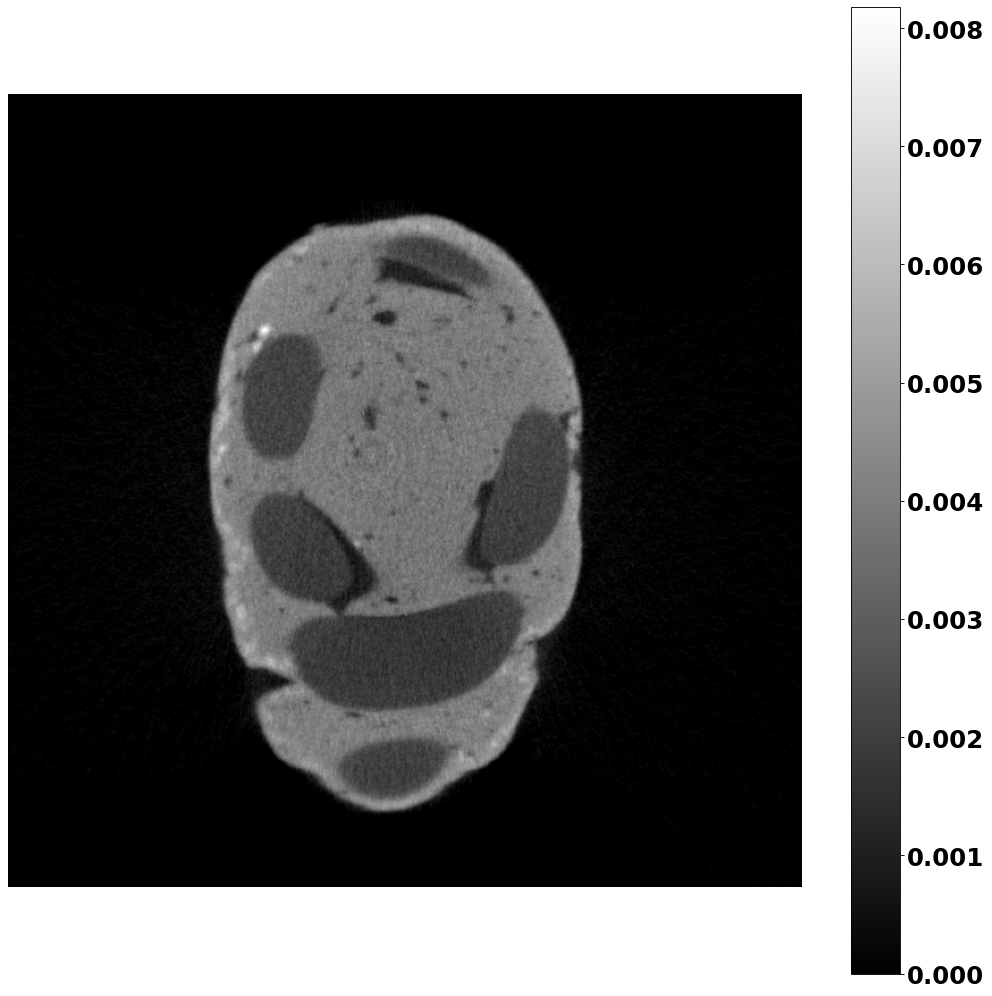

In [16]:
plt.figure(figsize=(16, 16), dpi=80)
plt.imshow(rec[800:1500,800:1500], cmap="gray")
plt.axis("off")
plt.colorbar()
plt.savefig("SIRT361.png")

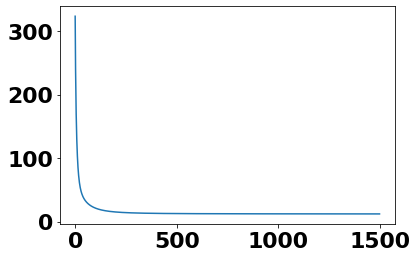

In [17]:
plt.plot(residual_error)